In [1]:
#!/usr/bin/env python
"""non_supervise: Advanced Pipeline of TF-IDF."""

__author__      = "Louis-Fiacre Franchet d'Espèrey"
__copyright__   = "Copyright 2022"
__commentary__ = "Adaptated by Perrine Maurel with the explicit agreement of {__author__} and the help of Violette Saïag."

In [2]:
import os
import pandas as pd

In [3]:
dir_fr = "../../textes_fr"
#dir_en = "../../textes_en"
titres_fr = [name_file for name_file in os.listdir(dir_fr) if name_file.endswith('.txt')]
#titres_en = [name_file for name_file in os.listdir(dir_en) if name_file.endswith('.txt')]
list_textes_fr = [] #on crée une liste vide pour accueillir nos résultats
for titre in titres_fr : 
    with open(os.path.join(dir_fr,titre), 'r', encoding='utf-8') as file: #on ouvre et on lit le fichier
        list_textes_fr.append(file.read())

In [4]:
corpus_path = r"../../textes_fr"

## tokeniser les textes en amont (très long)

In [5]:
import spacy
nlp = spacy.load('fr_core_news_md')

c:\Users\Perrine\anaconda3\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'fr_core_news_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
def tokenize_text(text):

    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha and not token.is_punct and not token.like_num:
            tokens.append(token)
    return tokens

In [7]:
list_textes_fr_tokened = [tokenize_text(text) for text in list_textes_fr]

# bag of word

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def bow(list_textes=list_textes_fr):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(use_idf=True, norm=None)),
    ])
    matrice = pipeline.fit_transform(list_textes) # version tokenisé
    cos = cosine_similarity(matrice, matrice)

    return cos

In [10]:
cos = bow()
cos

array([[1.        , 0.43994984, 0.48639141, ..., 0.46646899, 0.4219585 ,
        0.33423799],
       [0.43994984, 1.        , 0.53888177, ..., 0.50191914, 0.45123806,
        0.39561795],
       [0.48639141, 0.53888177, 1.        , ..., 0.5404434 , 0.50702808,
        0.42857497],
       ...,
       [0.46646899, 0.50191914, 0.5404434 , ..., 1.        , 0.48457944,
        0.38798761],
       [0.4219585 , 0.45123806, 0.50702808, ..., 0.48457944, 1.        ,
        0.38085896],
       [0.33423799, 0.39561795, 0.42857497, ..., 0.38798761, 0.38085896,
        1.        ]])

In [11]:
np.fill_diagonal(cos, 0)
cos

array([[0.        , 0.43994984, 0.48639141, ..., 0.46646899, 0.4219585 ,
        0.33423799],
       [0.43994984, 0.        , 0.53888177, ..., 0.50191914, 0.45123806,
        0.39561795],
       [0.48639141, 0.53888177, 0.        , ..., 0.5404434 , 0.50702808,
        0.42857497],
       ...,
       [0.46646899, 0.50191914, 0.5404434 , ..., 0.        , 0.48457944,
        0.38798761],
       [0.4219585 , 0.45123806, 0.50702808, ..., 0.48457944, 0.        ,
        0.38085896],
       [0.33423799, 0.39561795, 0.42857497, ..., 0.38798761, 0.38085896,
        0.        ]])

In [12]:
cosflat = np.reshape(cos, (cos.shape[0]**2,))

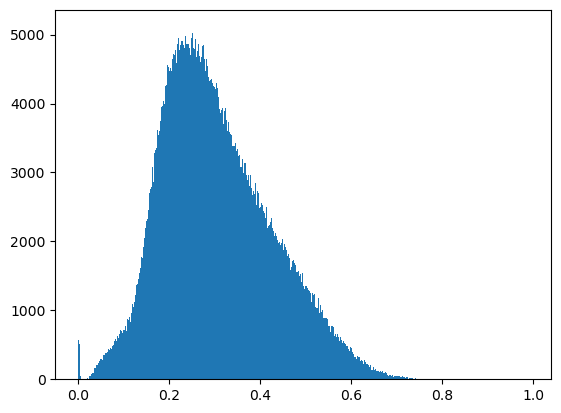

In [13]:
plt.hist(cosflat, bins=1000)
#plt.xlim([0,0.2])
plt.show()

In [14]:
import igraph as ig
def graph_from_adjmat(adjmat,labels=None,directed=False):
    """ Generate igraph graph from numpy adjacency matrix
    
    Parameters:
    adjmat (np.array): numpy array of shape (N,N) where N is the number of nodes
    labels (list,optional): list of strings that correspond to the node names in the right order of the adjacency matrix
    directed (bool): whether the graph should be directed or undirected
    
    Returns:
    G (igraph.Graph)    
    """
    if directed == False:
        G = ig.Graph.Adjacency((adjmat > 0).tolist(),mode='undirected')
    else:
        G = ig.Graph.Adjacency((adjmat > 0).tolist(),mode='directed')
    
    if labels != None:
        G.vs['name'] = labels
    
    return G

In [15]:
labels = titres_fr

In [16]:
seuil = float(0.70)
A = cos.copy()
A[A<seuil]=0
print(A)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
# Create graph, A.astype(bool).tolist() or (A / A).tolist() can also be used.
G = ig.Graph.Adjacency((A > 0).tolist(),mode='undirected')
G.vs['label'] = labels
# add edge and node metadata
G.es['weight'] = A[A.nonzero()]

In [18]:
G = G.components().giant()

In [19]:
from ipysigma import Sigma
Sigma(G, node_size=G.degree, node_color=G.betweenness(), node_color_gradient='Viridis',node_label=G.vs['label'])

Sigma(ig.Graph with 133 nodes and 606 edges)

In [20]:
Sigma(G, node_metrics=["louvain"], node_color="louvain", node_size=G.degree,node_label=G.vs['label'])

Sigma(ig.Graph with 133 nodes and 606 edges)

In [21]:
for label in G.vs['label']:
    if 'scp'==label[:3]:
        print(label)

scp-255-fr.txt
scp-383-fr.txt
scp-497-fr.txt
scp-503-fr.txt


In [22]:
communities = G.community_edge_betweenness()
communities = communities.as_clustering()

In [23]:
num_communities = len(communities)
palette = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    G.vs[community]["color"] = i
    community_edges = G.es.select(_within=community)
    community_edges["color"] = i

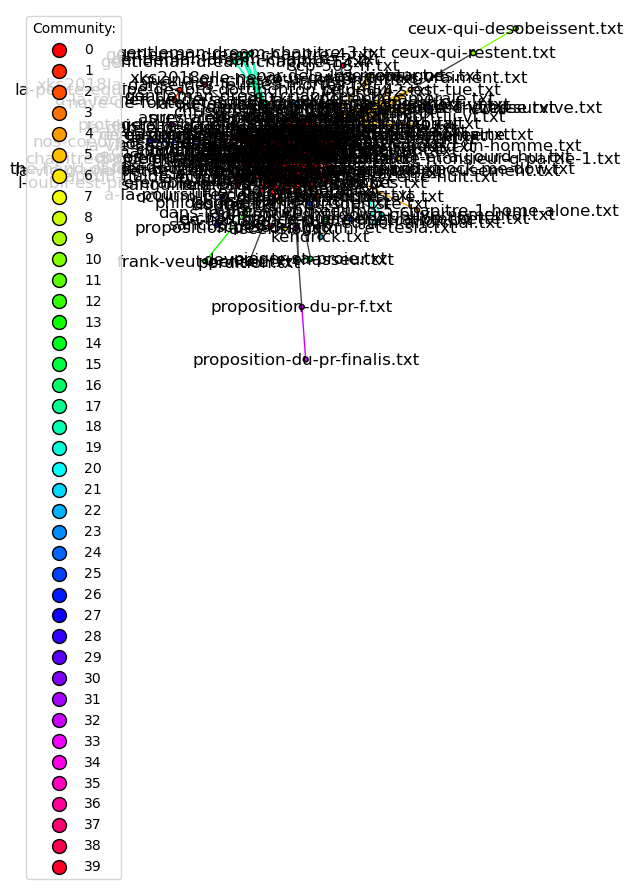

In [24]:
fig, ax = plt.subplots()
ig.plot(
    communities,
    palette=palette,
    edge_width=1,
    target=ax,
    vertex_size=0.3,
)

# Create a custom color legend
legend_handles = []
for i in range(num_communities):
    handle = ax.scatter(
        [], [],
        s=100,
        facecolor=palette.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)
ax.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax.transAxes,
)
plt.show()